In [1]:
import os
import netCDF4
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML

from scipy import ndimage
import cv2

In [2]:
input_path  = '/g/data/kl02/jss548/bonn-project-data/radolan_data/radolan_nc'
output_path = '/g/data/kl02/jss548/bonn-project-data/radolan_png'
bad         = np.nan
min_value   = -32.5
x_start     = 145 #values in x dim less this this aren't present
input_fn    = 'RX-2013-08-06.nc'
timestep    = 200

In [3]:
#read nc file
input_ffn = os.path.join(input_path, input_fn)
with netCDF4.Dataset(input_ffn) as ncid:
    refl_data = np.squeeze(ncid['rx'][:, :, :]).filled(min_value)
    time_list = np.squeeze(ncid['time'][:])
    time_units = ncid.variables['time'].units

In [4]:
#calculate convolutions
def refl_to_int(ref):
    return np.floor(ref/5)*5

n         = 2
pad_value = np.floor(min_value/5)*5
g1_size   = 2*n + 1
g2_size   = 4*n + 3
min_refl  = 0.
max_refl  = 30.

kernel_dilate = np.ones((3,3),np.uint8)
kernel_erode  = np.ones((3,3),np.uint8)
kernel_open   = np.ones((3,3),np.uint8)

In [ ]:
def animate_lbdt(i):
    plt.clf()
    #extract refl data
    refl_img_all = refl_data[i, :,:]
    #crop to valid data
    refl_img_crop = refl_img_all[:, x_start:]
    refl_img = refl_img_crop.copy()
    refl_img[refl_img<0]  = 0
    refl_img[refl_img>30] = 30

    #precip dilation
    refl_img_maxfilter = ndimage.filters.maximum_filter(refl_img,size=3)

    #uniform filter
    unifilt_array_1 = refl_to_int(ndimage.uniform_filter(refl_img_maxfilter, size=7, mode='constant', cval=0))
    unifilt_array_2 = refl_to_int(ndimage.uniform_filter(refl_img_maxfilter, size=15, mode='constant', cval=0))

    #filer by labelling regions and checking 95% of reflectivity
    labeled_array, num_features = ndimage.label(unifilt_array_1>0)
    label_filter = np.zeros_like(labeled_array)

    for label_idx in np.arange(0,num_features):
        refl_median = np.percentile(refl_img_maxfilter[labeled_array==label_idx], 95)
        if refl_median>20:
            label_filter[labeled_array==label_idx]=1

    label_filter_dilated = ndimage.binary_dilation(label_filter, structure=np.ones((3, 3)))        

    ridges_2 = refl_img_maxfilter-unifilt_array_2
    ridges_2[~label_filter_dilated==0] = 0
    ridges_2[ridges_2<0] = 0
    
    labeled_array_2, num_features_2 = ndimage.label(ridges_2>0)
    ridges_clean = ridges_2.copy()
    for label_idx in np.arange(0,num_features_2):
        refl_count  = np.sum([labeled_array_2==label_idx])
        refl_median = np.percentile(refl_img_maxfilter[labeled_array_2==label_idx], 95)
        if refl_median>15:
            ridges_clean[labeled_array_2==label_idx]=0
        if refl_count < 50:
            ridges_clean[labeled_array_2==label_idx]=0
    
    ax1 = fig.add_subplot(121)
    im1 = ax1.imshow(refl_img_crop)
    ax1.set_title('Intensity Reduced Reflectivity')
    fig.colorbar(im1, ax=ax1)

    ax2 = fig.add_subplot(122)
    im2 = ax2.imshow(ridges_clean)
    ax2.set_title('clutter')
    fig.colorbar(im2, ax=ax2)

    
fig = plt.figure(figsize=(20, 10))
ani_object = ani.FuncAnimation(fig, animate_lbdt, frames=len(time_list))

#Save animation to gif
anim_name = 'dbzh_animation_' + dt.now().strftime('%H%M%S') +'.gif'
ani_object.save(anim_name,
          writer='imagemagick', fps=5)
plt.close()
#show gif in notebook
print('complete')
HTML('<img src="' + anim_name + '">')
    

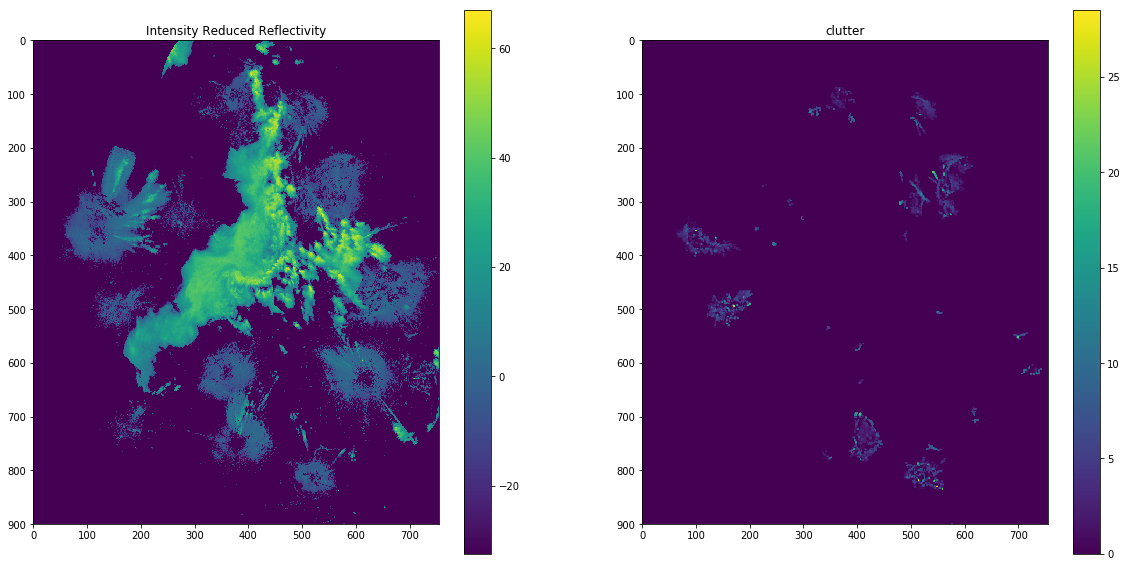

In [12]:
#extract refl data
refl_img_all = refl_data[timestep, :,:]
#crop to valid data
refl_img_crop = refl_img_all[:, x_start:]
refl_img = refl_img_crop.copy() + 5
refl_img[refl_img>30] = 30
refl_img[refl_img<0] = 0

#precip dilation
refl_img_maxfilter = ndimage.filters.maximum_filter(refl_img, size=3, cval=0)

#uniform filter
unifilt_array_1 = refl_to_int(ndimage.uniform_filter(refl_img_maxfilter, size=7, mode='constant', cval=0))
unifilt_array_2 = refl_to_int(ndimage.uniform_filter(refl_img_maxfilter, size=15, mode='constant', cval=0))

#filer by labelling regions and checking 95% of reflectivity
labeled_array, num_features = ndimage.label(unifilt_array_1 > 15)
label_filter = np.zeros_like(labeled_array)

for label_idx in np.arange(0,num_features):
    refl_median = np.percentile(refl_img_maxfilter[labeled_array==label_idx], 75)
    if refl_median>20:
        label_filter[labeled_array==label_idx]=1

label_filter_dilated = ndimage.binary_dilation(label_filter, structure=np.ones((3, 3)))        
        
ridges_2 = refl_img_maxfilter.copy() - unifilt_array_2

#next steps

# Decide where to take ridging filter... Need to find a way to seperate boundaries from area of convection before running a label check mask.
# Perhaps use unifilter area to find edges of convection?
# once we can seperate the linear extensions regions from convection, it should be possible to use label filtering properly.

ridges_2[ridges_2<0] = 0

labeled_array_2, num_features_2 = ndimage.label(ridges_2>0)
ridges_clean = ridges_2.copy()
for label_idx in np.arange(0,num_features_2):
    refl_count  = np.sum([labeled_array_2==label_idx])
    refl_median = np.percentile(refl_img_maxfilter[labeled_array_2==label_idx], 95)
    if refl_median>15:
        ridges_clean[labeled_array_2==label_idx]=0
    if refl_count < 50:
        ridges_clean[labeled_array_2==label_idx]=0

fig, axarr = plt.subplots(1, 2, figsize=(20, 10))

im1 = axarr[0].imshow(refl_img_crop)
axarr[0].set_title('Intensity Reduced Reflectivity')
fig.colorbar(im1, ax=axarr[0])

im2 = axarr[1].imshow(ridges_clean)
axarr[1].set_title('clutter')
fig.colorbar(im2, ax=axarr[1])
#plt.savefig('test.png', dpi=200)

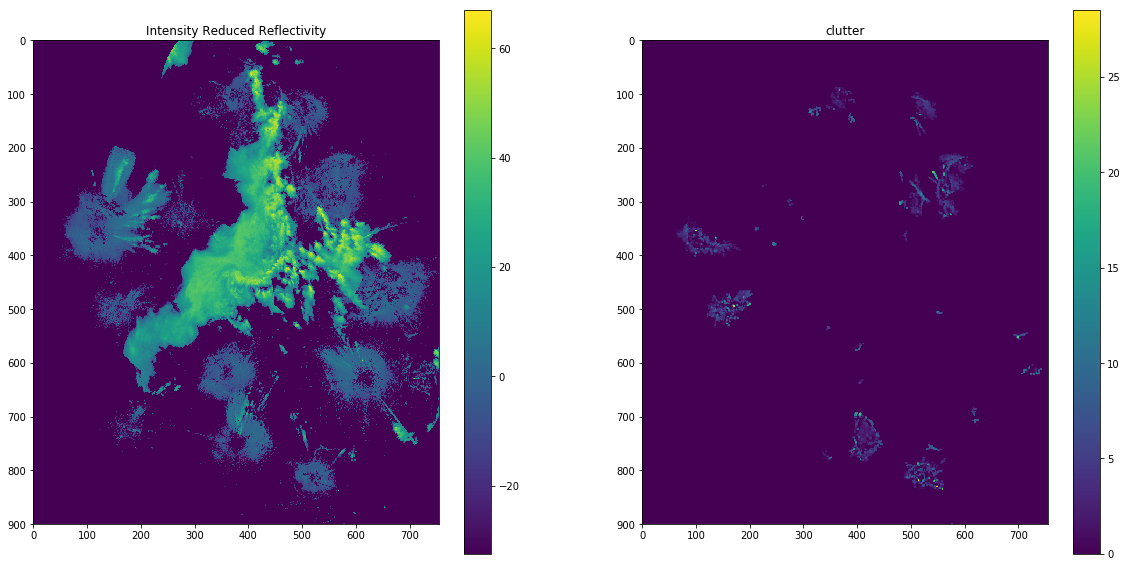

In [13]:
#extract refl data
refl_img_all = refl_data[timestep, :,:]
#crop to valid data
refl_img_crop = refl_img_all[:, x_start:]
refl_img = refl_img_crop.copy() + 5
refl_img[refl_img>30] = 30
refl_img[refl_img<0] = 0

#precip dilation
refl_img_maxfilter = ndimage.filters.maximum_filter(refl_img, size=3, cval=0)

#uniform filter
unifilt_array_1 = refl_to_int(ndimage.uniform_filter(refl_img_maxfilter, size=7, mode='constant', cval=0))
unifilt_array_2 = refl_to_int(ndimage.uniform_filter(refl_img_maxfilter, size=15, mode='constant', cval=0))

ridges_2 = refl_img_maxfilter.copy() - unifilt_array_2
ridges_2[ridges_2<0] = 0

labeled_array_2, num_features_2 = ndimage.label(ridges_2>0)
ridges_clean = ridges_2.copy()
for label_idx in np.arange(0,num_features_2):
    refl_count  = np.sum([labeled_array_2==label_idx])
    refl_median = np.percentile(refl_img_maxfilter[labeled_array_2==label_idx], 95)
    if refl_median>15:
        ridges_clean[labeled_array_2==label_idx]=0
    if refl_count < 50:
        ridges_clean[labeled_array_2==label_idx]=0

fig, axarr = plt.subplots(1, 2, figsize=(20, 10))

im1 = axarr[0].imshow(refl_img_crop)
axarr[0].set_title('Intensity Reduced Reflectivity')
fig.colorbar(im1, ax=axarr[0])

im2 = axarr[1].imshow(ridges_clean)
axarr[1].set_title('clutter')
fig.colorbar(im2, ax=axarr[1])
#plt.savefig('test.png', dpi=200)